In [ ]:
!pip install git+https://github.com/pe8sutd/eda4u &> /dev/null
!git clone https://github.com/pe8sutd/eda4u &> /dev/null
%load_ext plugin

The plugin extension is already loaded. To reload it, use:
  %reload_ext plugin


# **FPGA Fingerprint Tarot Fortune Reader using Hénon Map PRNG**

# **Video Demo & Explanation**
In this video we show how the system works and how it gathers data, processes it and provides us with a 24-bit random number to be sent to the Raspberry pi to be displayed on the screen as Tarot Cards and Fortune reading.
https://www.youtube.com/watch?v=RqVWFEaKl3I



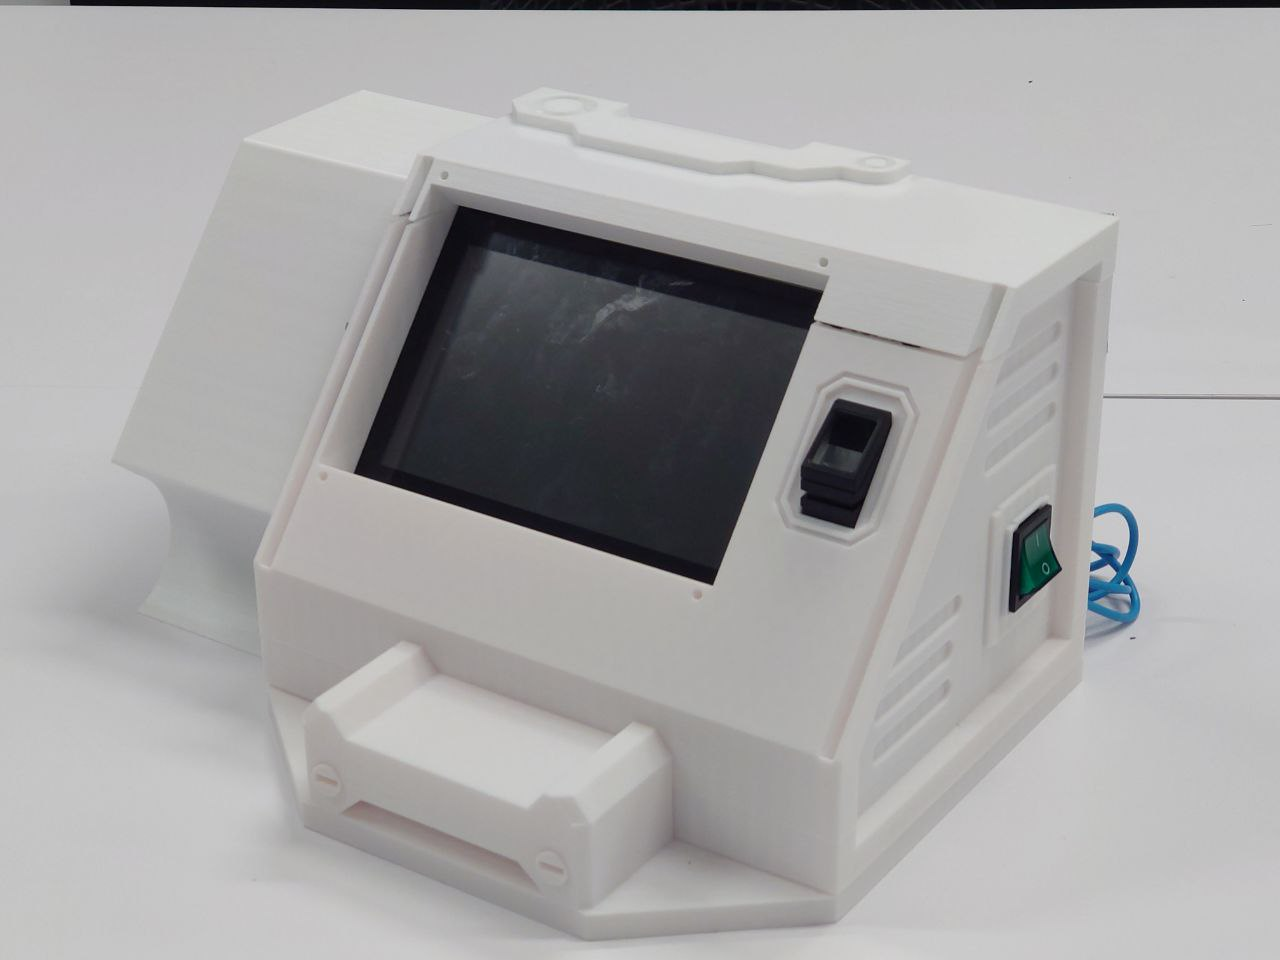

# **State machine and module explanation**

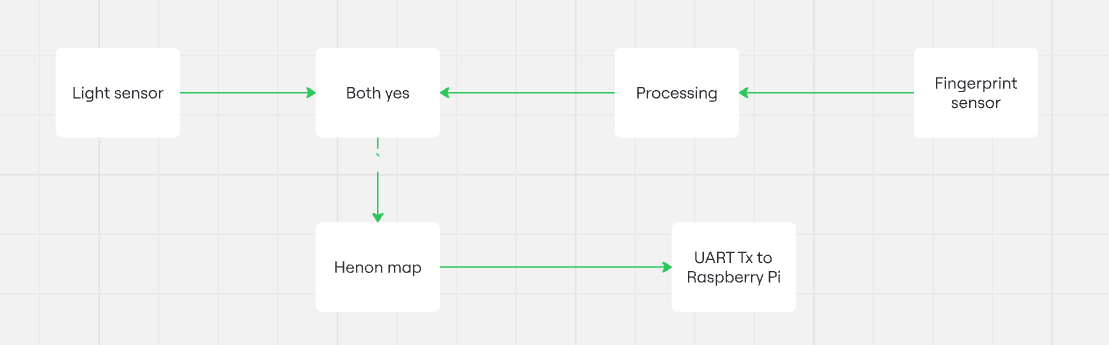
Fig 1: state checking

The FPGA checks the outputs of both the processing and the light sensor to see if it has completed it's tasks. This then allows us to send the data to the Henon map which will do it's PRN generation. After it is completed, the Henon map module will send a signal to the UART Tx module, which sends the 24-bits of data from the FPGA to the Raspberry Pi.

The ADC reader and the Clk divider was done and reviewed in Lab 3 and as such will not be covered in this report.

The UART was recreated to allow for simple edits from our side. This allowed us to view the state and be able to determine if infomation was being sent and received.

The Henon map takes 2 32-bit data and uses it to simulate a chaotic system, which we explored more in depth with the report.

# **Logic-gate Code**

For the logic gate FPGA, our code used in the program is shown below. It was created by TA Mao Yang to test the CMOD FPGA being used in the current iteration


In [ ]:
module Top(
    input sysclk,
    input rst_n,
    input pio1,
    output pio2,
    output adc_din,
        output adc_clk,
        output adc_csn,
    input  adc_dout,
    output [1:0] led,
    output pio7,
    output pio8
);

parameter CLK_FREQ = 12_000_000;
   parameter RX_BAUD = 57_600;
    parameter TX_BAUD = 9_600;
    parameter TOTAL_BYTES = 50;
wire [7:0] rx_data;
wire rx_done;
wire [31:0] avg_value;
reg [31:0] Segment_data;
wire avg_done;
wire tx_busy;
reg [7:0] tx_data;
wire CLK1Hz;
wire clk2Mhz;
reg start;
wire adc_vaild;
assign pio7 = avg_done;
assign pio8 = start;
assign led = tx_state;

localparam  SINGLE_CHAN0  = 2'b10;
localparam  SINGLE_CHAN1  = 2'b11;

reg adc_ready;
wire [11:0] adc_data;

// Clk divder to get the 2Mhz for ADC
clock_div u1( rst_n,sysclk,clk2Mhz);
clock_div u2(rst_n,sysclk,CLK1Hz);

defparam u2.FREQ_OUTPUT = 500;


drv_mcp3202 drv_mcp3202_u0(
    .rstn(rst_n),
    .clk(clk2Mhz),
    .ap_ready(adc_ready),
    .ap_vaild(adc_vaild),
    .mode(SINGLE_CHAN0),
    .data(adc_data),

    .port_din(adc_dout),
    .port_dout(adc_din), //adc_din
    .port_clk(adc_clk),
    .port_cs(adc_csn)
);

// ADC SAMPLING EVENT (FREQ:1HZ)
always @(posedge rst_n, posedge adc_vaild,posedge CLK1Hz) begin
    if(rst_n) begin
        adc_ready <= 1'b0;
        Segment_data <= 32'h0;
    end else begin
        if(adc_vaild) begin
            Segment_data <= adc_data;
            adc_ready <= 1'b0;
        end
        else begin
            adc_ready <= 1'b1;
        end
    end
end
// UART RX Instance (57.6k baud)
UART_RX rx_inst (
    .clk(sysclk),
    .FPGA_RX(pio1),
    .rx_data(rx_data),
    .rx_done(rx_done)
);

// Average Calculator
fingerprint_mean_processing avg_inst (
    sysclk,
    clk2Mhz,
    rst_n,
    pio1,
    avg_value,
    avg_done
    );

// UART TX Instance (9.6k baud)
UART_TX tx_inst (
    .clk(sysclk),
    .tx_start(tx_start),
    .tx_data(tx_data),
    .tx(pio2),
    .tx_done(tx_busy)
);

//sample for both starts
always @(posedge sysclk) begin
 if (avg_done) begin
 start <= 1'b1;
 end
 else begin
 start <= 0;
 end
 end

//initialize henonmap
//reg [31:0] a;
//reg [31:0] b;
wire Henon_done;
wire [31:0] x_out;
wire [31:0] y_out;

//initial begin
//a = 14;
//b= 3;
//end
//henon_map_q31 q1(clk2Mhz, rst_n, start, avg_value, Segment_data,a,b,x_out,y_out,Henon_done);

henon_prng_top #(
    .TOTAL_ITER(8)
) prng_inst(
    .clk(clk2Mhz),
    .rst(rst_n),
    .start(start),
    .seed_q31(adc_data),
    .fingerprint_mean(avg_value),
    .random_out_x(x_out),
    .random_out_y(y_out),
    .done(Henon_done)
);

reg [1:0] henon_count;
// 32-bit Transmission Control
reg [31:0] tx_buffer;
reg [2:0] tx_state;
reg [1:0] byte_count;
reg tx_start;
reg [2:0] tx_state;



localparam TX_IDLE  = 2'b01,
           TX_START = 2'b10,
           TX_WAIT  = 2'b11;



always @(posedge sysclk or posedge rst_n) begin
    if(rst_n) begin
        henon_count <= 0;
        tx_state <= TX_IDLE;
        byte_count <= 0;
        tx_start <= 0;
        tx_data <= 8'h00;
        tx_buffer <= 32'h00000000;
    end
    else begin
        case(tx_state)
            TX_IDLE: begin
                if(Henon_done & tx_buffer!=x_out) begin
                    tx_buffer <= x_out;
                    tx_state <= TX_START;
                    byte_count <= 0;
                end
            end

            TX_START: begin
                case(byte_count)
                    2'b00: tx_data <= tx_buffer[15:8];
                    2'b01: tx_data <= tx_buffer[23:16];
                    2'b10: tx_data <= tx_buffer[31:24];
                endcase
                tx_start <= 1'b1;
                tx_state <= TX_WAIT;
            end

            TX_WAIT: begin
                tx_start <= 1'b0;
                if(!tx_busy) begin
                    // Wait for transmission to start
                    tx_state <= TX_WAIT;
                end else begin
                    // Transmission complete
                    if(byte_count == 2'b11) begin
                        tx_state <= TX_IDLE;
                    end else begin
                        byte_count <= byte_count + 1'b1;
                        tx_state <= TX_START;
                    end
                end
            end
        endcase
    end
end



endmodule

In [ ]:
module fingerprint_mean_processing(
input sysclk,
    input clk,
    input rst_n,
    input uart_rx,
    output reg [31:0] avg_out,
    output reg done_avg
);

// UART RX Interface
wire [7:0] rx_data;
wire rx_done;
parameter TOTAL_BYTES = 50;
parameter CLK_FREQ = 12_000_000;
parameter BAUD_RATE = 57_600;
parameter MAX_SUM_THRESHOLD = 12750;

// UART RX Instantiation
 UART_RX uart_rx_inst (
    .clk(sysclk),
    .FPGA_RX(uart_rx),
    .rx_data(rx_data),
    .rx_done(rx_done)
);

// Expanded registers for 32-bit output
reg [31:0] sum;
reg [14:0] byte_count;
reg [1:0] state;

// Modified division parameters
localparam DIVIDE_CYCLES = 63;  //
reg [5:0] div_counter;          // 6 bits
reg [47:0] dividend;            // 48-bit dividend
reg [15:0] divisor;
reg [31:0] quotient;            // 32-bit quotient

// State definitions
localparam IDLE = 2'b00,
           ACCUMULATE = 2'b01,
           CALC_AVG = 2'b10;

always @(posedge clk or posedge rst_n) begin
    if(rst_n) begin
        sum <= 32'b0;
        byte_count <= 15'b0;
        avg_out <= 32'b0;
        done_avg <= 1'b0;
        state <= IDLE;
        dividend <= 48'b0;
        divisor <= 16'b0;
        quotient <= 32'b0;
        div_counter <= 6'b0;
    end
    else begin
        case(state)
            IDLE: begin
                if(rx_done) begin
                    sum <= rx_data;       // Initial sum with sign extension
                    byte_count <= 15'b1;
                    done_avg <= 1'b0;
                    div_counter <= 6'b0;
                    state <= ACCUMULATE;
                end
            end

            ACCUMULATE: begin
                if(rx_done & rx_data != 8'hFF & rx_data != 8'h00) begin
                    sum <= sum + rx_data;  // 32-bit accumulation
                    byte_count <= byte_count + 1'b1;
                end

                if(byte_count == TOTAL_BYTES) begin
                    if (sum <= MAX_SUM_THRESHOLD) begin
                        dividend <= {sum, 16'b0};  // 48-bit dividend for fixed-point
                        divisor <= TOTAL_BYTES;
                        state <= CALC_AVG;
                    end else begin
                        done_avg <= 1'b0;
                        state <= IDLE;
                    end
                end
            end

            CALC_AVG: begin
                if(div_counter < DIVIDE_CYCLES) begin
                    // Modified division for 48-bit dividend
                    if(dividend[47:32] >= divisor) begin
                        dividend <= {dividend[47:32] - divisor, dividend[31:0], 1'b1};
                        quotient <= {quotient[30:0], 1'b1};
                    end else begin
                        dividend <= {dividend[46:0], 1'b0};
                        quotient <= {quotient[30:0], 1'b0};
                    end
                    div_counter <= div_counter + 1'b1;
                end else begin
                    avg_out <= quotient;  // Full 32-bit output
                    done_avg <= 1'b1;
                    state <= IDLE;
                end
            end
        endcase
    end
end

endmodule

In [ ]:
module henon_prng_top (
    input wire clk,
    input wire rst,
    input wire start,
    input wire [31:0] seed_q31,
    input wire [31:0] fingerprint_mean, // 32-bit mean in Q1.31
    output reg [31:0] random_out_x,   // Final 32-bit x output in Q1.31
    output reg [31:0] random_out_y,   // Final 32-bit y output in Q1.31
    output reg done
);

    // 1.4 in decimal => ~0xB3333333 in Q1.31
    // 0.3 in decimal => ~0x26666666 in Q1.31
    localparam signed [31:0] A_Q31 = 32'hB3333333;  // ~1.4
    localparam signed [31:0] B_Q31 = 32'h26666666;  // ~0.3

    //--------------------------------------------------------------------
    // Internal regs
    //--------------------------------------------------------------------
    reg [1:0] state;
    reg [31:0] x, y;          // current x,y in Q1.31
    reg iter_start;           // single-cycle pulse to henon_map_q31
    reg [7:0] iter_count;
    wire iter_done;
    wire signed [31:0] x_next, y_next;

    // We'll do a rising-edge detect on iter_done
    reg iter_done_d;
    wire iter_done_rising = iter_done & ~iter_done_d;

    parameter TOTAL_ITER = 8;
    //--------------------------------------------------------------------
    // Henon iteration module (one iteration per start pulse)
    //--------------------------------------------------------------------
    henon_map_q31 iter_unit (
        .clk(clk),
        .rst(rst),
        .start(iter_start),
        .x_in(x),
        .y_in(fingerprint_mean), // use fingerprint_mean as initial y
        .a(A_Q31),
        .b(B_Q31),
        .x_out(x_next),
        .y_out(y_next),
        .done(iter_done)
    );

    //--------------------------------------------------------------------
    // FSM states
    //--------------------------------------------------------------------
    localparam IDLE = 2'd0,
               RUN  = 2'd1,
               WAIT = 2'd2,
               DONE_ST = 2'd3;



    //--------------------------------------------------------------------
    // Main FSM
    //--------------------------------------------------------------------
    always @(posedge clk or posedge rst) begin
        if (rst) begin
            state <= IDLE;
            done <= 0;
            iter_start <= 0;
            iter_count <= 0;
            x <= 0;
            y <= 0;
            random_out_x <= 0;
            random_out_y <= 0;
            iter_done_d <= 0;
        end else begin
            iter_done_d <= iter_done; // rising-edge track

            case (state)
                IDLE: begin
                    iter_start <= 0;
                    done <= 0;
                    if (start) begin
                        // load seed into x
                        x <= seed_q31;
                        y <= fingerprint_mean;
                        iter_count <= 0;
                        state <= RUN;
                    end
                end

                RUN: begin
                    iter_start <= 1;
                    state <= WAIT;
                end

                WAIT: begin
                    iter_start <= 0;
                    // wait for iteration done
                    if (iter_done_rising) begin
                        // update x,y
                        x <= x_next;
                        y <= y_next;
                        iter_count <= iter_count + 1;

                        if (iter_count + 1 == TOTAL_ITER) begin
                            // final output
                            random_out_x <= x_next;
                            random_out_y <= y_next;
                            done <= 1;
                            state <= DONE_ST;
                        end else begin
                            // do another iteration
                            state <= RUN;
                        end
                    end
                end

                DONE_ST: begin

                    if (!start) begin
                        state <= IDLE;
                    end
                end

                default: state <= IDLE;
            endcase
        end
    end

endmodule



In [ ]:
module henon_map_q31 (
    input wire clk,
    input wire rst,
    input wire start,
    input wire signed [31:0] x_in,
    input wire signed [31:0] y_in,
    input wire signed [31:0] a,
    input wire signed [31:0] b,
    output reg signed [31:0] x_out,
    output reg signed [31:0] y_out,
    output reg done
);

    reg [1:0] state;
    reg signed [71:0] x_sq, ax2;
    reg signed [71:0] x_sq, ax2, y_accum;
    reg start_d, start_rising;

    localparam IDLE = 2'd0,
               STEP1 = 2'd1,
               STEP2 = 2'd2,
               DONE = 2'd3;

    // Q1.31 representation of 1.0
    localparam signed [71:0] ONE_Q31 = 1;

    always @(posedge clk or posedge rst) begin
        if (rst) begin
            x_out <= 0;
            y_out <= 0;
            start_d <= 0;
            start_rising <= 0;
            state <= IDLE;
        end else begin
            start_rising <= start & ~start_d;
            start_d <= start; // latch old 'start'

            case (state)
                IDLE: begin
                    done <= 0;
                    if (start_rising) begin
                        x_sq <= (x_in * x_in);
                        state <= STEP1;
                    end
                end

                STEP1: begin
                    // (a * x_sq) >> 31 to bring Q2.62 => Q1.31
                    ax2 <= (a * x_sq) >>> 31;
                    state <= STEP2;
                end

                STEP2: begin
                    // x_{n+1} = 1.0 - a * x^2 + y + perturb
                    x_out <= ONE_Q31 - ax2[31:0] + y_in;
                    // y_{n+1} = (b * x) >> 31
                    y_accum = b * x_in;
                    y_out <= y_accum >>> 31;
                    state <= DONE;
                end

                DONE: begin
                    done <= 1;
                    state <= IDLE;
                end
            endcase
        end
    end

endmodule

In [ ]:
module UART_TX(
    input clk,          // 12 MHz clock
    input tx_start,     // Trigger transmission (pulse)
    input [7:0] tx_data,// Data to transmit
    output reg tx,      // Serial output
    output reg tx_done  // Transmission complete
);

// Parameters
parameter CLK_FREQ = 12_000_000;   // 12 MHz
parameter BAUD_RATE = 9600;
parameter BIT_PERIOD = CLK_FREQ / BAUD_RATE;  // 1250 cycles/bit

// States
reg [1:0] state;
localparam IDLE = 2'b00, START = 2'b01, DATA = 2'b10, STOP = 2'b11;

// Transmission registers
reg [10:0] counter;     // 11-bit counter (counts up to 1250)
reg [2:0] bit_index;    // Tracks which bit is being sent
reg [7:0] data_buffer;  // Holds data during transmission

// Initialize
initial begin
    state = IDLE;
    tx = 1'b1;          // UART idle state is high
    tx_done = 0;
    counter = 0;
    bit_index = 0;
    data_buffer = 0;
end

// State Machine
always @(posedge clk) begin
    case (state)
        IDLE: begin
            tx <= 1'b1;         // Maintain idle state
            tx_done <= 0;
            if (tx_start) begin
                state <= START;
                data_buffer <= tx_data; // Latch input data
                counter <= 0;
            end
        end

        START: begin
            tx <= 1'b0;         // Start bit (low)
            if (counter == BIT_PERIOD - 1) begin
                state <= DATA;
                counter <= 0;
                bit_index <= 0;
            end else
                counter <= counter + 1;
        end

        DATA: begin
            tx <= data_buffer[0]; // Send LSB first
            if (counter == BIT_PERIOD - 1) begin
                data_buffer <= data_buffer >> 1; // Shift right
                counter <= 0;
                if (bit_index == 7)
                    state <= STOP;
                else
                    bit_index <= bit_index + 1;
            end else
                counter <= counter + 1;
        end

        STOP: begin
            tx <= 1'b1;         // Stop bit (high)
            if (counter == BIT_PERIOD - 1) begin
                state <= IDLE;
                tx_done <= 1;  // Pulse done signal
                counter <= 0;
            end else
                counter <= counter + 1;
        end
    endcase
end

endmodule

In [ ]:
module UART_RX(
    input clk,          // 12 MHz system clock
    input FPGA_RX,      // Asynchronous UART input
    output reg [7:0] rx_data,
    output reg rx_done
);

// Parameters for 12 MHz clock and 9600 baud
parameter CLK_FREQ = 12_000_000;   // 12 MHz
parameter BAUD_RATE = 57600;
parameter SAMPLING_COUNT = CLK_FREQ / BAUD_RATE;  // cycles/bit

// States
reg [1:0] state;
localparam IDLE = 2'b00, START = 2'b01, DATA = 2'b10, STOP = 2'b11;

// Synchronization and sampling registers
reg [1:0] sync_reg;     // Metastability protection
reg rx_sync;            // Synchronized RX signal
reg [10:0] counter;     // 11-bit counter (needs to count up to 1250)
reg [2:0] bit_index;    // 3-bit counter for 8 data bits

// Initialize
initial begin
    state = IDLE;
    rx_done = 0;
    rx_data = 0;
    sync_reg = 2'b11;   // Default to idle state (high)
    rx_sync = 1;
    counter = 0;
    bit_index = 0;
end

// Synchronize FPGA_RX to clk (avoid metastability)
always @(posedge clk) begin
    sync_reg <= {sync_reg[0], FPGA_RX};  // Shift in RX signal
    rx_sync <= sync_reg[1];              // Stable synchronized value
end

// State Machine
always @(posedge clk) begin
    case (state)
        IDLE: begin
            rx_done <= 0;       // Reset done flag
            if (!rx_sync) begin // Start bit detected (falling edge)
                state <= START;
                counter <= 0;   // Reset counter for start bit
            end
        end

        START: begin
            // Wait until middle of start bit (1250/2 = 625 cycles)
            if (counter == (SAMPLING_COUNT/2)-1) begin    // 625-1 (0-based counting)
                if (!rx_sync) begin      // Confirm valid start bit
                    state <= DATA;
                    counter <= 0;
                    bit_index <= 0;
                end else
                    state <= IDLE;       // False start, return to idle
            end else
                counter <= counter + 1;
        end

        DATA: begin
            // Sample data bits at middle of each bit period (1250 cycles)
            if (counter == SAMPLING_COUNT -1) begin   // 1250-1 (0-based)
                rx_data[bit_index] <= rx_sync;  // LSB first (bit_index 0 = LSB)
                counter <= 0;
                if (bit_index == 7)      // After 8 bits, move to STOP
                    state <= STOP;
                else
                    bit_index <= bit_index + 1;
            end else
                counter <= counter + 1;
        end

        STOP: begin
            // Wait for middle of stop bit (optional: verify it's high)
            if (counter == (SAMPLING_COUNT/2)-1) begin   // Sample middle of stop bit
                rx_done <= 1;           // Pulse done signal
                state <= IDLE;          // Return to idle
                // Optional: Check if rx_sync == 1 here for framing error
            end else
                counter <= counter + 1;
        end
    endcase
end

endmodule

Test bench

In [ ]:
`timescale 1ns / 1ps
//////////////////////////////////////////////////////////////////////////////////
// Company:
// Engineer:
//
// Create Date: 04/03/2025 06:27:20 PM
// Design Name:
// Module Name: henon_prng_tb
// Project Name:
// Target Devices:
// Tool Versions:
// Description:
//
// Dependencies:
//
// Revision:
// Revision 0.01 - File Created
// Additional Comments:
//
//////////////////////////////////////////////////////////////////////////////////

module henon_prng_tb;

    // 1) Combine or separate these properly:
    reg clk = 0;
    reg rst;
    reg start;
    reg [31:0] seed;

    reg [31:0] fingerprint_mean;

    wire [31:0] random_out_x;
    wire [31:0] random_out_y;
    wire done;

    henon_prng_top dut (
        .clk(clk),
        .rst(rst),
        .start(start),
        .seed_q31(seed),
        .fingerprint_mean(fingerprint_mean),
        .random_out_x(random_out_x),
        .random_out_y(random_out_y),
        .done(done)
    );

    // 2) Clock generation
    always #5 clk = ~clk;

    initial begin
        $display("Starting Henon PRNG testbench...");

        // Initialize fingerprint_mean here
        fingerprint_mean = 32'h12345678;

        // Reset sequence
        rst = 1;
        start = 0;
        seed = 32'h00123456;
        #20;
        rst = 0;
        #10;

        // Start PRNG
        start = 1;
        #10;
        start = 0;

        // Wait for result
        wait (done);
        $display("Random Output X: %h", random_out_x);
        $display("Random Output Y: %h", random_out_y);
        #20;
        $stop;
    end

endmodule


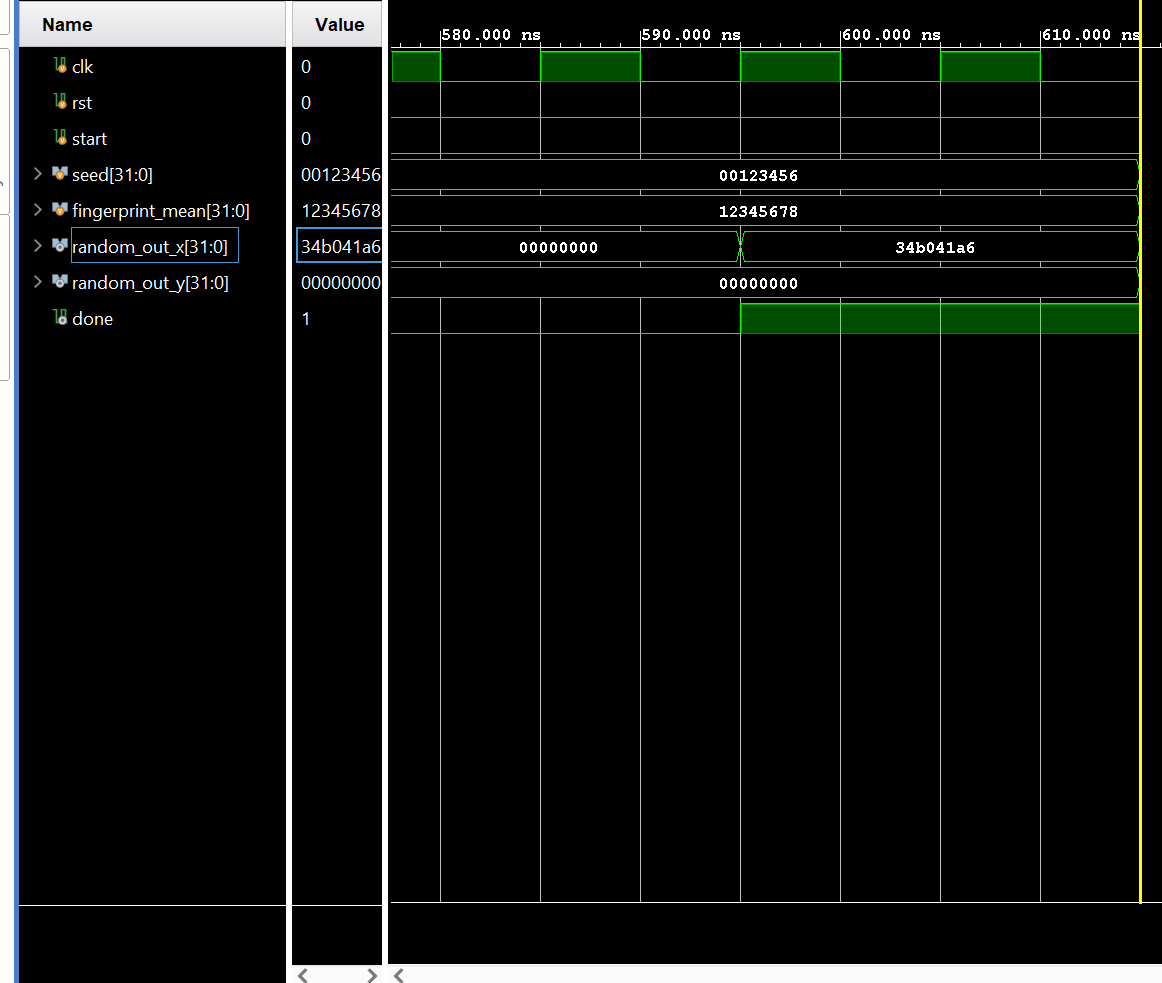
Fig 2: Testbench waveform

Using this code, we were able to identify and the data being generated from the Henon map to be of the right format. We then used a python script to test if the numbers were distributed randomly.

In [ ]:
# Hénon constants in Q1.31  (α = 1.4, β = 0.3)
A_Q31 = 0xB333_3333
B_Q31 = 0x2666_6666
ONE   = 0x8000_0000
MASK  = 0xFFFF_FFFF

# ------------------------------------------------------------
# 2.  Fixed-point helpers
# ------------------------------------------------------------
def q31_mul(a: int, b: int) -> int:
    """signed Q1.31 × Q1.31 → Q1.31"""
    prod = (a * b) & 0xFFFF_FFFF_FFFF_FFFF  # 64-bit wrap-around
    if prod & (1 << 63):                    # sign-extend
        prod -= 1 << 64
    return (prod >> 31) & MASK

def henon_q31(x: int, y: int):
    """one iteration of 2-D Hénon map"""
    x_sq = q31_mul(x, x)
    ax2  = q31_mul(A_Q31, x_sq)
    xn1  = (ONE - ax2 + y) & MASK
    yn1  = q31_mul(B_Q31, x)
    return xn1, yn1

# ------------------------------------------------------------
# 3.  Generate raw stream (no whitening)
# ------------------------------------------------------------
xs = np.empty(SAMPLES, dtype=np.uint32)
x, y = x0_q31, y0_q31
for i in range(SAMPLES):
    x, y = henon_q31(x, y)
    xs[i] = x                 # store raw x_n

# ------------------------------------------------------------
# 4.  Analyse bytes 0-2 (LSB .. byte-2)
# ------------------------------------------------------------
def analyse_byte(byte_vals, idx):
    hist  = np.bincount(byte_vals, minlength=256)
    chi2, p = stats.chisquare(hist, f_exp=np.full(256, hist.sum()/256))
    print(f"byte {idx}  χ² p-value = {p:.4f}")

    plt.figure()
    plt.hist(byte_vals, bins=256, color='orange')
    plt.title(f"Histogram – byte {idx} (shift {idx*8})")
    plt.xlabel("value 0-255"); plt.ylabel("count")
    plt.tight_layout()

for idx, shift in enumerate((0, 8, 16)):           # last three bytes
    analyse_byte((xs >> shift) & 0xFF, idx)

# ------------------------------------------------------------
# 5.  Histogram of the least-significant 24 bits  (uniform check)
# ------------------------------------------------------------
vals24 = xs & 0x00FF_FFFF         # keep only the lowest 24 bits

plt.figure()
# range=(0, 2**24) forces the x-axis to be the real 24-bit values
plt.hist(vals24, bins=256, range=(0, 2**24), color='orange')
plt.title("Histogram of the LSB-24 of xₙ  ({} samples)".format(SAMPLES))
plt.xlabel("24-bit value  (0x000000 … 0xFFFFFF)")
plt.ylabel("count")
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(np.arange(1000), vals24[:1000], '.-', markersize=2)
plt.title("LSB-24 values versus iteration  (first 1 000)")
plt.xlabel("iteration"); plt.ylabel("24-bit value")
plt.tight_layout()

plt.show()

This provided us with a distrubtion as shown below which shows us the random nature of the PRNG.

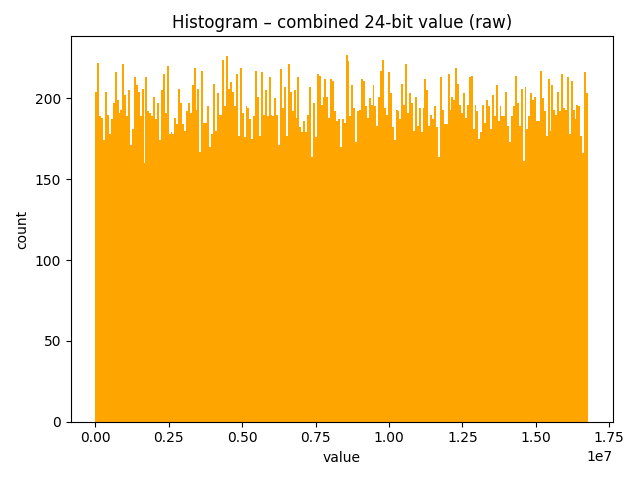

Fig 3: Plot of numbers from Henon Map

# **Design Rationale**

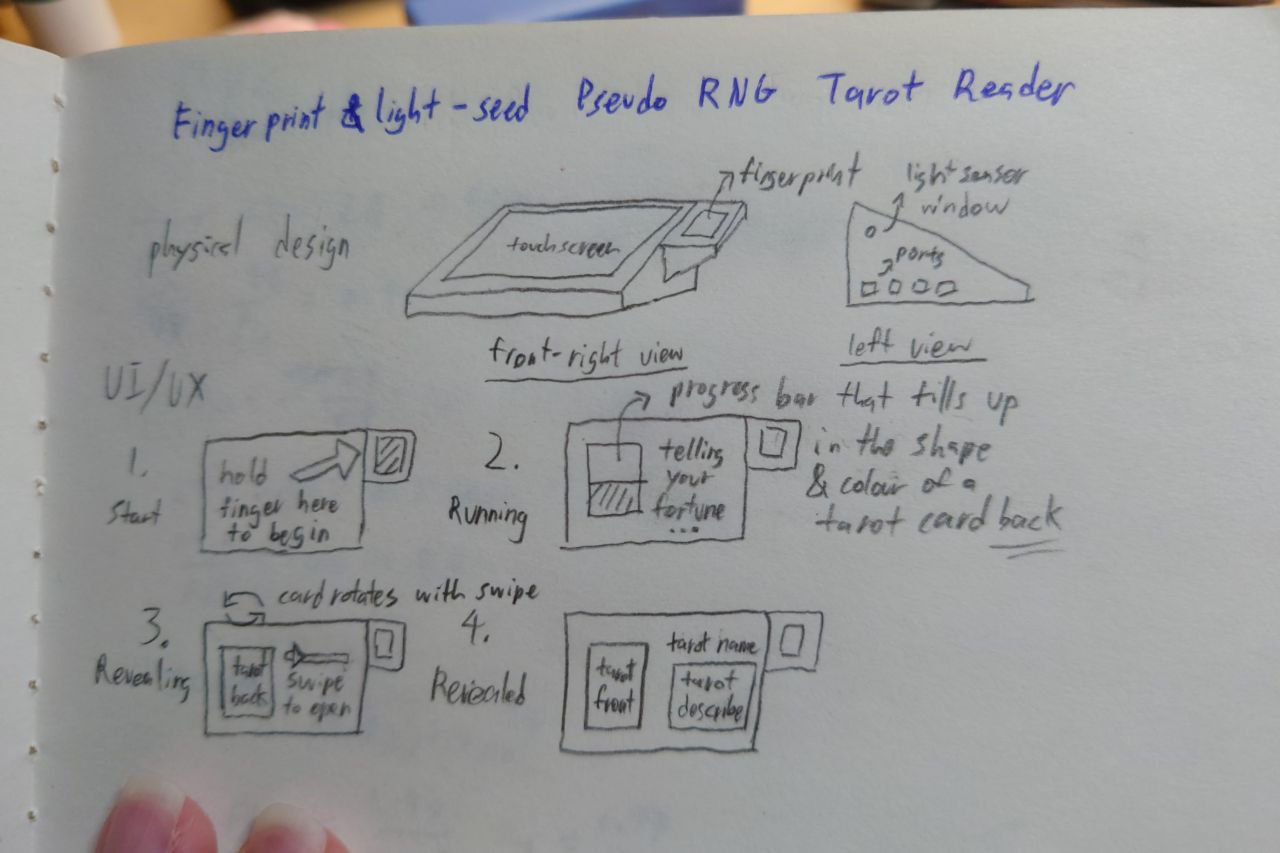

For the **Overarching Design Rationale**, we made the concept sketch (image above) with user-friendliness in mind. To do this, we had a discussion and decided that the most time- and effort-effective method was to make our design completely touch-based. By using a touchscreen and fingerprint scanner, we can avoid the complexity and reliability issues with designing and incorporating moving parts. While the touchscreen allows us to easily design and update artistic flair and instructions to optimize user enjoyment and ease-of-use, without needing to manually paint or write every update. And instead focus on spending our time in getting the PRNG code to work flawlessly, which is the main purpose of this project.




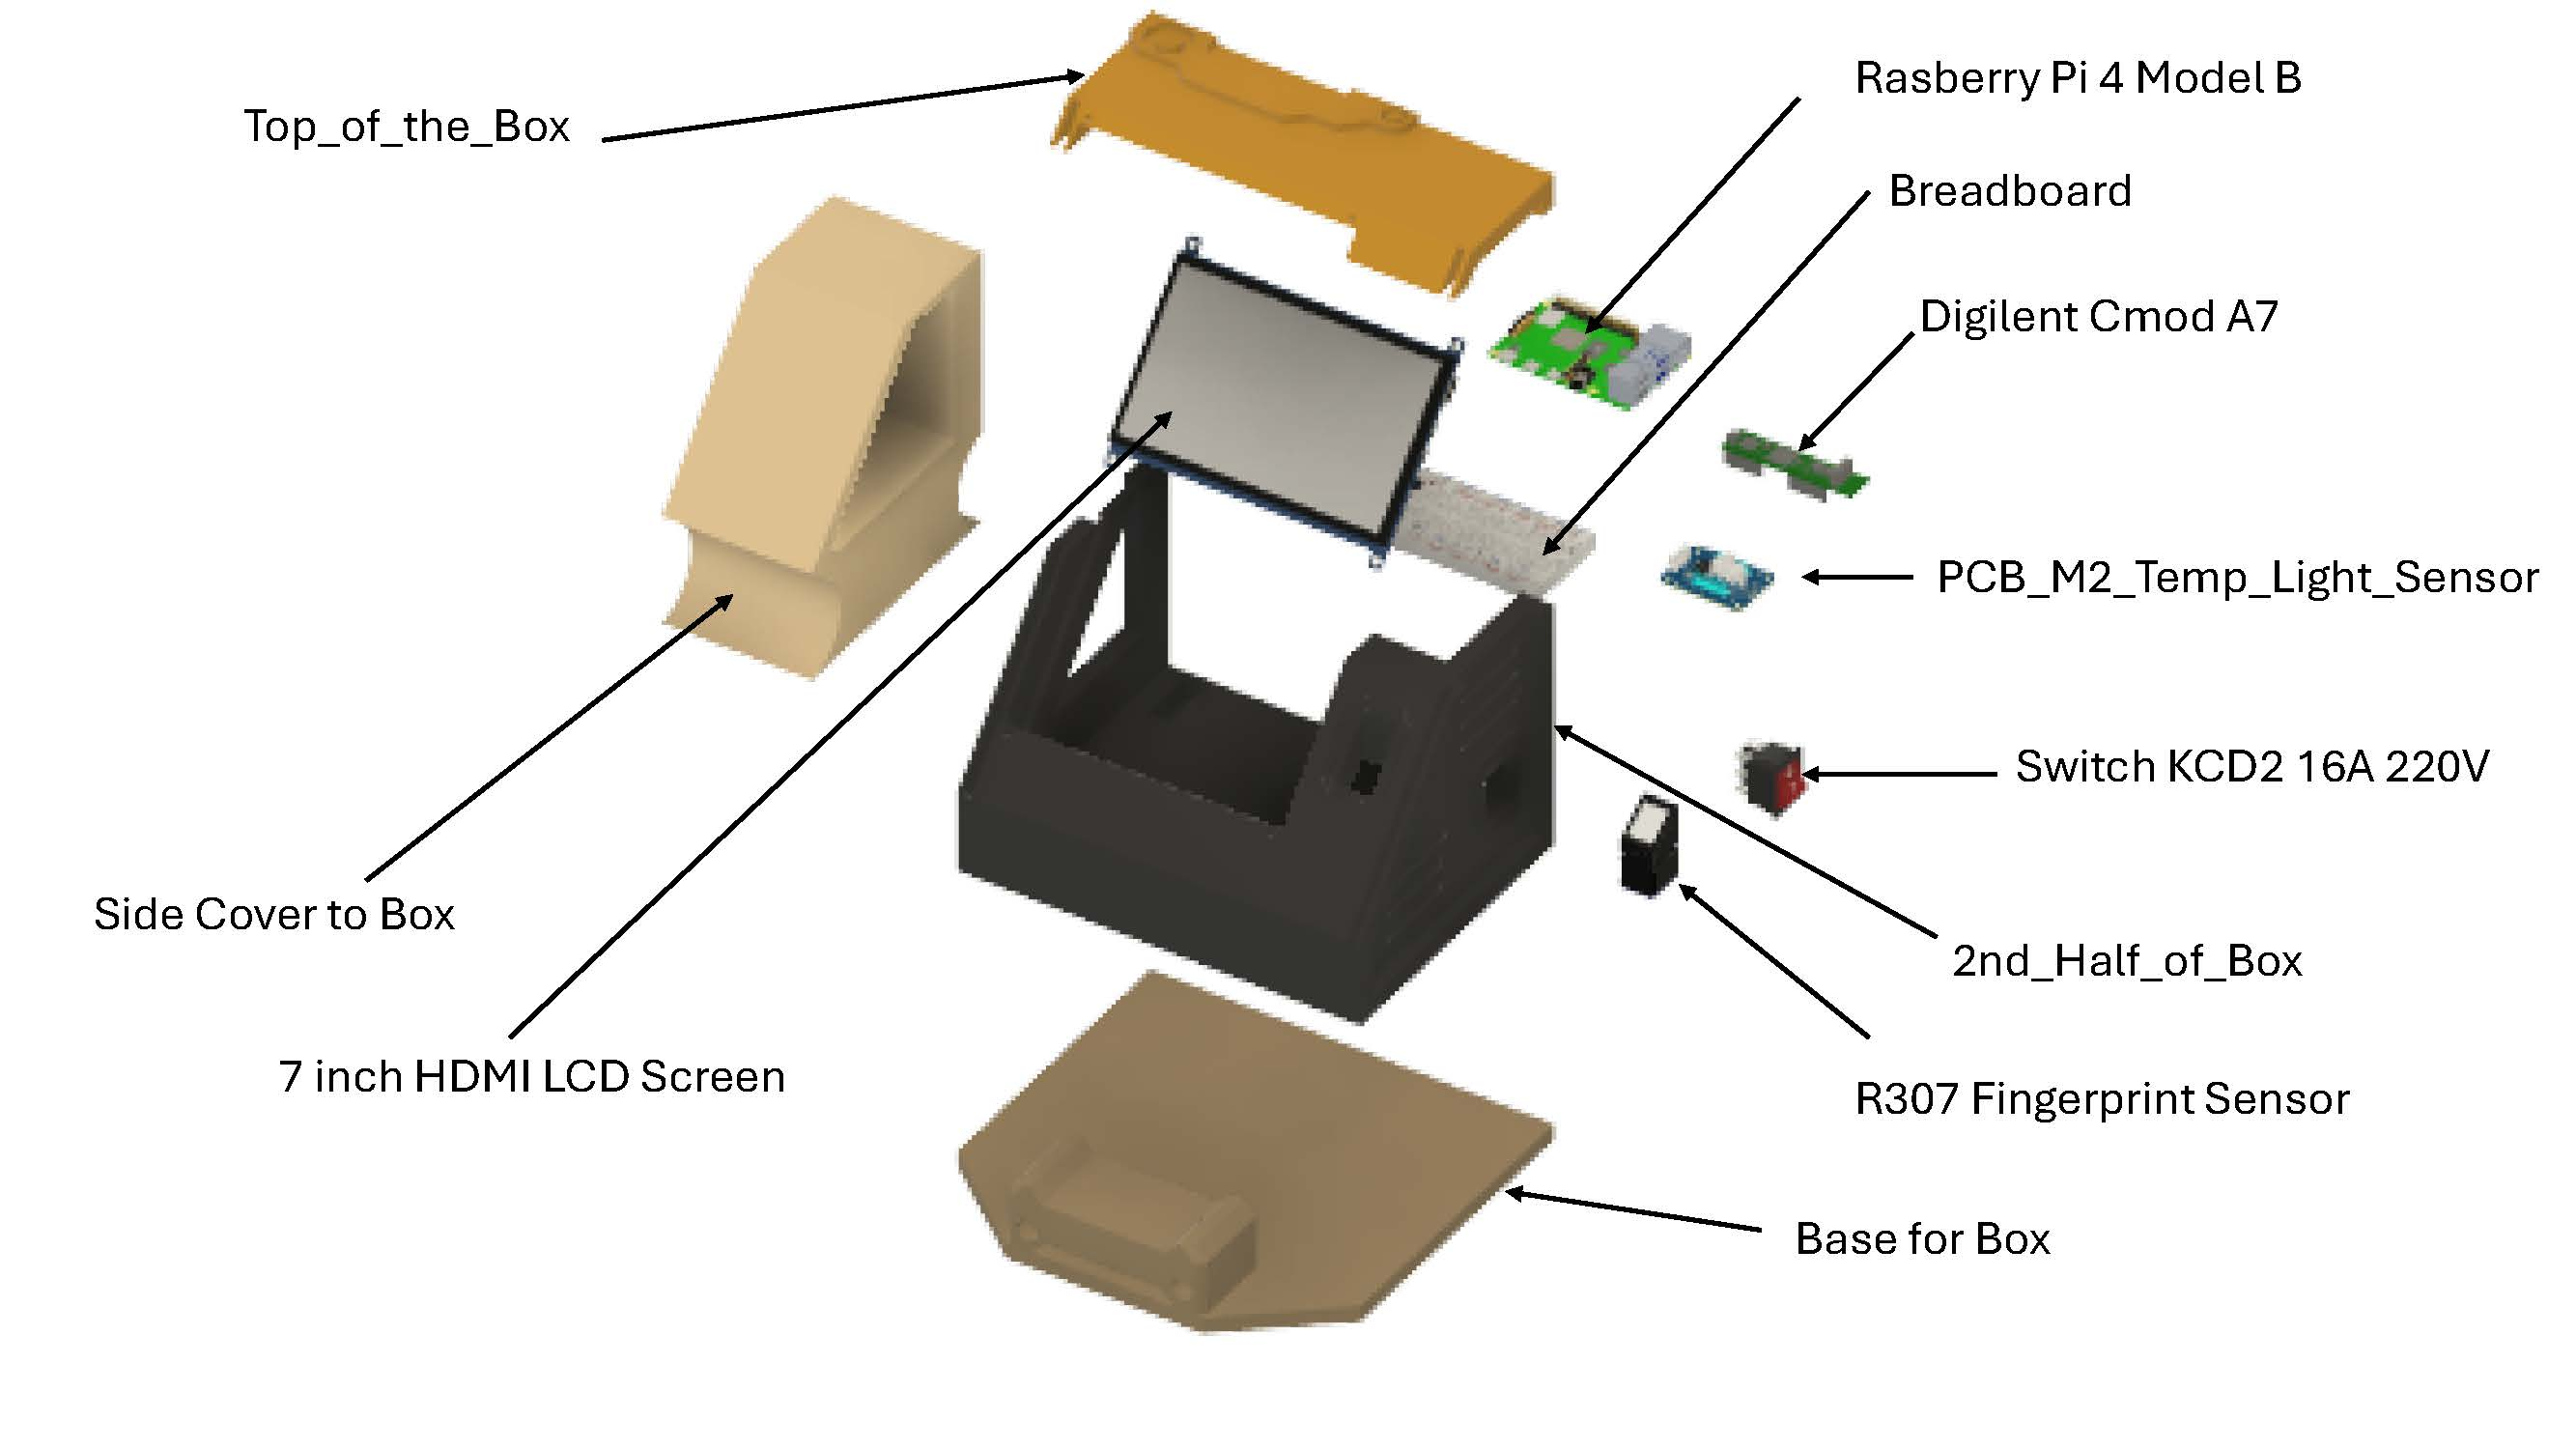

**As we continued to refine our design**, we designed it in CAD to be made with 3D printing, as that would allow us the most customizability for our aesthetic design, and would allow us to make custom crevices to hold all the components inside (image above) while providing easy wiring and accessibility for troubleshooting with our actual prototype (image below).

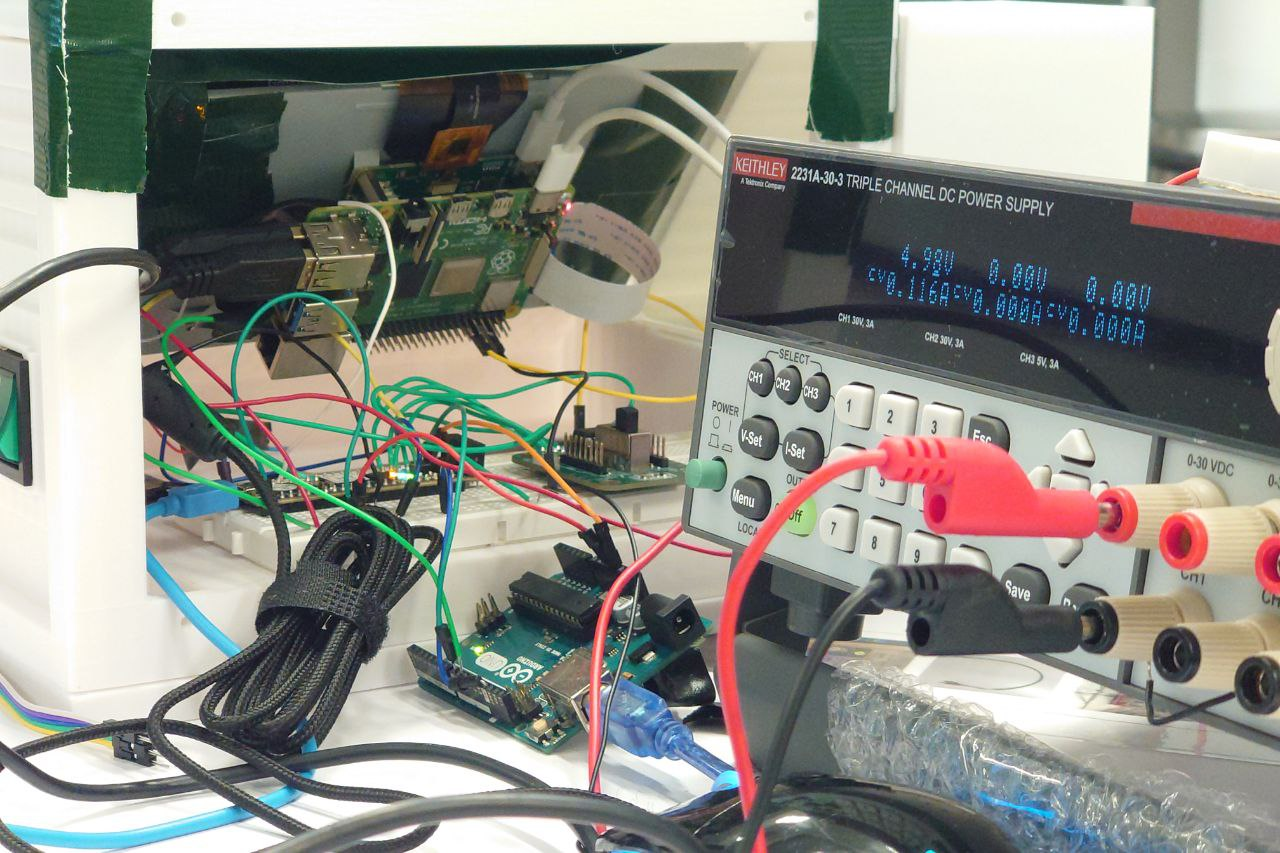

**Software Design Rationale**

**The pseudorandom number generator code** in this project was designed around the two-dimensional Hénon map, a 2D dissipative quadratic map governed by:

𝑥𝑛+1=1−𝛼𝑥2𝑛+𝑦𝑛
x
n
+
1
=
1
−
𝛼
x
n
2
+
y
n


𝑦𝑛+1=𝛽𝑥𝑛
y
n
+
1
=
𝛽
x
n


Where the constants α = 1.4 and β = 0.3 allows the Hénon map to be its classical chaotic regime and produce a “boomerang” attractor that never settles to a short orbit [2].  

With only one quadratic term and single linear feedback, the Hénon map requires just two multiplications and one addition per iteration. Thus, implementation of electronics would be relatively inexpensive due to low calculation burden. In addition, since x and y feed into each other at every iteration, the entropy injected into either variable, which in this case is the fingerprint-image mean for y0 and the light-sensor seed for x0, is quickly blurred across the full 64-bit state. One dimensional map such as the logistic or tent functions cannot provide the same cross-coupling and are more prone to short numerical cycles when quantized [3]. Since many implementations of Hénon maps have been used in encryption schemes, it holds promise in being used as PRNG in this project [1] [2].

 **The validity of the PRNG was assessed off-chip with a Python test-bench.** Using a Python implementation of the 2D Hénon map, the Hénon map was validated as a PRNG. Since only the least significant 24 bits of xn were used to produce the 3 tarot cards, a histogram was generated using the least significant 24 bits. **As seen above in Figure 3, the least significant 24 bits produce a uniform distribution and show no significant pattern. Thereby successfully fulfilling our purpose of PRNG.**

**Electronics Design Rationale**

We designed the Touchscreen to be connected to a Raspberry Pi, which would have more computing and memory required to display images and stylized text on the screen, compared to the CMOD 7A that we were using for the PRNG calculations. To get the Touchscreen, Raspberry Pi, Fingerprint scanner, CMOD 7A to trigger and operate together when the touchscreen was pressed, an Arduino Uno was designed as the coordinator.

# **Challenges, Lesssons Learnt and Solutions**

**Software-wise**

**Synchronization of Data Streams**
A significant challenge in the software design stemmed from the need to synchronize two distinct data streams that operated at different frequencies from. the Fingerprint Sensor and CMOD 7A. This timing discrepancy created a critical issue where the Hénon map component either received an excessive number of starting signals in rapid succession or, conversely, failed to receive any signals at all. Such inconsistency disrupted the intended functionality of the pseudorandom number generator (PRNG).

To address this, we carefuly observed and tuned comunication protocol by measuring the actual output with an oscilloscope. , a precision diagnostic tool that enables the visualization of electrical signals in real time.

**Data Transmission Integrity**
Another notable issue arose when certain bits failed to transmit or receive correctly between system components. This problem jeopardized the integrity of the data flow, which is critical for the accurate generation of pseudorandom numbers. To diagnose the root cause, we reutilized the oscilloscope. By analyzing the waveforms, we were able to verify the correctness of the hardware connections and confirm whether the signals being sent adhered to the expected patterns.

This meticulous examination revealed inconsistencies output signal, which we promptly rectified by ensuring secure connections and proper grounding troublemating wires. The use of the oscilloscope was instrumental in identifying these discrepancies, allowing us to restore reliable data transmission and safeguard the system’s overall performance.

**Fingerprint Sensor Overheating**
During prolonged stress testing and troubleshooting sessions exceeding one hour, we encountered an undocumented error code, 0xFF, from the fingerprint sensor. This anomaly prompted a detailed investigation into its cause. Leveraging a thermal camera, we monitored the sensor’s temperature and discovered that its internal circuitry was overheating under sustained operational loads. The thermal imaging confirmed a direct correlation between elevated temperatures and the occurrence of the error code.

To mitigate this issue, we instituted a protocol whereby the system is powered down for a cooling period of 5 to 10 minutes following intensive use. This straightforward yet effective measure has proven successful in preventing overheating, thereby ensuring the fingerprint sensor’s consistent and reliable performance. Additionally, we explored passive cooling solutions, such as improved ventilation around the sensor, to further enhance its thermal management in future iterations.

**Hardware-wise**

**3D Printing Challenges and Solutions**
A significant hurdle in our hardware development process emerged when we discovered that the university’s shared 3D printing facilities were fully booked for the next three weeks (due to other school projects running simultanuosly like Capstone, 3D-Prog, Archetecture, etc). This posed a critical challenge, as fabricating a physical prototype was essential for validating our design and ensuring proper integration of components. To address this, we took proactive measures by purchasing the required filament materials and arranging to borrow a personal 3D printer from a friend. This resourceful solution enabled us to proceed with the prototyping phase without significant delays, demonstrating our ability to adapt to scheduling constraints and maintain project progress. The successful production of the prototype reaffirmed the importance of flexibility and external collaboration in overcoming logistical obstacles.

**Display Screen Malfunction and Adaptation**
We encountered another hardware setback when the original touchscreen display malfunctioned and became inoperable. To diagnose the issue, we employed an oscilloscope, which revealed that an overvoltage condition in one of the connecting wires was the root cause. After correcting the voltage issue and ensuring proper wiring integrity, we replaced the damaged screen with a borrowed unit from a friend. However, the replacement screen had slightly different dimensions compared to the original, requiring us to manually adjust the existing enclosure. Through careful filing and the strategic use of duct tape, we modified the case to accommodate the new screen, ensuring a secure fit and full functionality. This process highlighted our technical troubleshooting skills and adaptability, allowing us to navigate unexpected hardware challenges effectively while keeping the project on track.



# **Innovation and Education**

**Technological Innovation**

Utilizing an FPGA to implement a pseudo-random number generator (PRNG) based on the Hénon map introduces a novel approach to generating entropy, enhancing the unpredictability and security of the system.  The fusion of chaotic mathematical models with tarot card symbolism creates a unique user experience, blending deterministic algorithms with interpretive art.  

At the heart of the Chaotic Tarot Reader, it is a fundamentally novel approach to biometric authentication.  

While most fingerprint-based systems rely on software processing - leaving them exposed to memory dumps, reverse engineering, and replay attacks - our design offloads the entire fingerprint pipeline onto an FPGA via On-Chip Fingerprint Processing Where Raw image data from the R307 sensor is streamed directly into FPGA logic. A FPGA-resident SHA-256 engine hashes the fingerprint template in real time, with encrypted Storage in BRAM so that only the 256-bit hash ever resides in on-chip Block RAM (BRAM). As such, no unencrypted fingerprint data or templates ever cross the FPGA boundary.   

The hardware implementation also eliminates OS - or firmware-level attack surfaces and cryptographic hashing prevents fingerprint reconstruction. Replay attacks are neutralized because each template is non-invertible and bound to the current session.

By processing, hashing, and storing biometric data wholly within the FPGA fabric, the system ensures end-to-end security at the hardware level - an industry-leading step beyond traditional software-based biometrics.

**Educational Value**

The project encompasses various fields - electronics, computer science, mathematics, and art—providing a holistic educational tool that encourages learners to explore multiple disciplines.  

Students gain practical experience with hardware components like FPGAs, ADCs, and microcontrollers, as well as software development for GUI applications, fostering a comprehensive understanding of system integration.  

Having to interpret the output of chaotic systems and relating them to symbolic representations like tarot cards encourages creative thinking and offers a platform for discussions on determinism, randomness, and interpretation.

**Broader Implications**

This project exemplifies how complex systems can be made accessible and engaging, serving as a model for educational tools that aim to demystify advanced concepts through interactive and personalized experiences.

# **Usage of AI**



Ai was used mainly to verify code and to help document it more with better anotations and better gramma. It was also used to help identify possible causes of various issues while troubleshooting our prototype and code, the model used was mostly ChatGPT 4o.



# **References**

[1]   D. Murillo-Escobar, M. Á. Murillo-Escobar, C. Cruz-Hernández et al., “Pseudorandom number generator based on novel 2D Hénon-Sine hyperchaotic map with microcontroller implementation,” Nonlinear Dynamics, vol. 111, pp. 6773–6789, Apr. 2023, doi: 10.1007/s11071-022-08101-2.

[2]  A. Soleymani, M. J. Nordin, and E. Sundararajan, “A chaotic cryptosystem for images based on Hénon and Arnold cat map,” The Scientific World Journal, vol. 2014, Art. no. 536930, Aug. 2014, doi: 10.1155/2014/536930.

[3] R. Lozi, “Complexity leads to randomness in chaotic systems,” in Complexity, Metastability and Nonextensivity, S. Abe, H. J. Herrmann, P. Quarati, A. Rapisarda, and C. Tsallis, Eds. Singapore: World Scientific, 2011, pp. 79–98, doi: 10.1142/9789814338820_0005.